# LangChain  Chain   :Preset chain:
LCEL LangGraph

Here are some guidelines:

If you are making a single LLM call, you don't need LCEL; instead call the underlying chat model directly.
If you have a simple chain (e.g., prompt + llm + parser, simple retrieval set up etc.), LCEL is a reasonable fit, if you're taking advantage of the LCEL benefits.
If you're building a complex chain (e.g., with branching, cycles, multiple agents, etc.) use LangGraph instead. Remember that you can always use LCEL within individual nodes in LangGraph.

Simple Chain = = Model I/O(prompt + llm + parser) ->LCEL
Complex Chain = LangGraph

preset chain:
LLMChain
SequentialChain
RouterChain
APIChain,LLMMathChain,RetrievalQA.....


## LLMChain:The simplest Chain

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
from langchain.prompts import PromptTemplate

template = "{flower}'s floral language?"

prompt_temp = PromptTemplate.from_template(template)

prompt = prompt_temp.format(flower='Rose')

print(prompt)

In [ ]:
from langchain_openai import OpenAI

model = OpenAI(temperature=0)

result = model(prompt)

print(result)

Rose's floral language is often associated with love, passion, and romance. Different colors of roses can also convey different meanings, such as red for love and desire, pink for gratitude and appreciation, and yellow for friendship and joy.


In [ ]:
#chain
from langchain.chains import LLMChain

template = "{flower}'s floral language?"
llm = OpenAI(temperature=0)

llm_chain = LLMChain(llm=llm,prompt=PromptTemplate.from_template(template))

print(llm_chain('Rose'))


{'flower': 'Rose', 'text': "\n\nRose's floral language is often associated with love, passion, and romance. Different colors of roses can also convey different meanings, such as red for love and desire, pink for gratitude and appreciation, and yellow for friendship and joy."}


In [ ]:
#LCEL
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

template = "{flower}'s floral language?"
flower_prompt = ChatPromptTemplate.from_messages([
    ("human", template)
])

chain = flower_prompt | llm | StrOutputParser()

chain.invoke({"flower": "Rose"})


'The language of flowers, or "floriography," assigns specific meanings to different flowers, and roses are among the most significant in this symbolic language. Here are some common meanings associated with various colors of roses:\n\n1. **Red Roses**: Love and passion. They are often given on romantic occasions, such as Valentine\'s Day or anniversaries.\n\n2. **White Roses**: Purity, innocence, and new beginnings. They are often used in weddings and symbolize a fresh start.\n\n3. **Yellow Roses**: Friendship and joy. They convey warmth and happiness, making them suitable for platonic relationships.\n\n4. **Pink Roses**: Gratitude, grace, and admiration. Lighter shades can symbolize sweetness, while darker shades can represent appreciation.\n\n5. **Orange Roses**: Enthusiasm and desire. They convey a sense of excitement and energy.\n\n6. **Lavender Roses**: Enchantment and love at first sight. They symbolize a sense of wonder and admiration.\n\n7. **Black Roses**: Often associated with mourning or the end of something, such as a relationship or a phase in life.\n\n8. **Blue Roses**: Mystery and the unattainable. Since blue roses do not naturally occur, they symbolize something that is desired but cannot be achieved.\n\nThese meanings can vary by culture and context, but they provide a general framework for understanding the sentiments conveyed through the gift of roses.'

In [ ]:
from langchain_core.runnables import RunnablePassthrough

outer_chain = RunnablePassthrough().assign(text=chain)

outer_chain.invoke({"flower": "Rose"})

{'flower': 'Rose',
 'text': 'The language of flowers, or "floriography," assigns specific meanings to different flowers, and roses are among the most significant in this symbolic language. Here are some common meanings associated with various colors of roses:\n\n1. **Red Roses**: Love and passion. They are often given on romantic occasions, such as Valentine\'s Day or anniversaries.\n\n2. **White Roses**: Purity, innocence, and new beginnings. They are often used in weddings and symbolize a fresh start.\n\n3. **Yellow Roses**: Friendship and joy. They convey warmth and happiness, making them suitable for platonic relationships.\n\n4. **Pink Roses**: Gratitude, grace, and admiration. Lighter shades often represent sweetness, while deeper pinks can signify appreciation.\n\n5. **Orange Roses**: Enthusiasm and desire. They express a sense of fascination and energy.\n\n6. **Lavender Roses**: Enchantment and love at first sight. They convey a sense of magic and admiration.\n\n7. **Black Roses**: Mourning or farewell. They can symbolize the end of something, such as a relationship or a life.\n\n8. **Blue Roses**: Mystery and the unattainable. Since blue roses do not naturally occur, they often represent something elusive.\n\nThese meanings can vary by culture and context, but they provide a general framework for understanding the sentiments associated with roses in the language of flowers.'}

In [ ]:
## SequentialChain
"""
Our goal is as follows:
step 1: we assume that the large model is a botanist,asking it to provide knowledge and introductions for a specific type of flower.
step 2: we assume that the large model is a flower reviewer,asking it to reference the text output from the botanist above and provide comments on the flower.
step 3: we assume that the large model is the social media manager for Flowers,asking it to reference the text output from both the botanist and the flower reviewer above to write a flower marketing copy.

TASK chain:
flower introductions
review
social media Post

"""

In [ ]:
from langchain.chains import SequentialChain
from langchain.chains import LLMChain
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import PromptTemplate

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
#LLMChain
template = """
You are botanist.Given the name and type of a flower,you need to write an introduction of about 200 words for this flower.

Name:{name}
Color:{color}
Botanist:Here is the introduction of the above flower:
"""
prompt_template = PromptTemplate(input_variables=["name","color"],template=template)
introduction_chain = LLMChain(llm=llm,prompt=prompt_template,output_key="introduction")


template = """
You are critic.Given an introduction of a flower,you need to write a review of about 200 words for this flower.

Flower introduction:
{introduction}
The flower critic's review of the above flower:
"""
prompt_template = PromptTemplate(input_variables=["introduction"],template=template)
review_chain = LLMChain(llm=llm,prompt=prompt_template,output_key="review")


template = """
You are a social media manager for a flower shop.Given an introduction and review of a flower,you need to write a social medial media post of about 300 words for this flower.

The flower critic's review of the above flower:
{review}

Social Media Post:
"""
prompt_template = PromptTemplate(input_variables=["review"],template=template)
social_post_chain = LLMChain(llm=llm,prompt=prompt_template,output_key="social_post")


In [ ]:
overall_chain = SequentialChain(
    chains=[introduction_chain,review_chain,social_post_chain],
    input_variables=["name","color"],
    output_variables=["introduction","review","social_post"],
    verbose=True
)

result = overall_chain({"name":"Rose","color":"black"})
print(result)


[1m> Entering new SequentialChain chain...[0m

[1m> Finished chain.[0m
{'name': 'Rose', 'color': 'black', 

'introduction': "The black rose, often shrouded in mystery and intrigue, is a captivating flower that has captured the imagination of many throughout history. While true black roses do not exist in nature, the deep, dark hues of certain varieties, such as the 'Black Baccara' or 'Black Magic,' create an illusion of blackness, showcasing rich, velvety petals that appear almost ebony under certain lighting conditions. These roses are often associated with themes of rebirth, elegance, and the enigmatic nature of love, making them a popular choice for special occasions and artistic expressions.\n\nIn the realm of symbolism, black roses can convey a range of meanings, from the end of a relationship to the celebration of new beginnings. They are frequently used in literature and art to represent the duality of beauty and darkness, evoking a sense of passion and intensity. Cultivated primarily in temperate climates, black roses thrive in well-drained soil and require ample sunlight to flourish. Their striking appearance and unique color make them a sought-after addition to gardens and floral arrangements, appealing to those who appreciate the unconventional and the extraordinary in the world of botany.", 

'review': "The black rose, with its enigmatic allure, stands as a testament to the beauty found in darkness. While true black roses are a myth, varieties like 'Black Baccara' and 'Black Magic' offer a stunning visual experience with their deep, velvety petals that flirt with the idea of true blackness. This flower transcends mere aesthetics; it embodies a rich tapestry of symbolism that resonates deeply with those who encounter it. \n\nIn the realm of floral arrangements, the black rose is a bold statement piece, often evoking a sense of mystery and sophistication. Its association with themes of rebirth and the complexities of love adds layers of meaning, making it a compelling choice for both joyous celebrations and somber farewells. The duality of beauty and darkness that the black rose represents is a powerful reminder of the intricate nature of human emotions.\n\nCultivating these roses requires a bit of care, as they thrive in well-drained soil and need ample sunlight. However, the effort is well worth it for those who appreciate the unconventional. In a world where traditional blooms often dominate, the black rose stands out as a striking symbol of individuality and depth, making it a must-have for any garden or floral enthusiast seeking to embrace the extraordinary.", 

'social_post': "🌹✨ Embrace the Enigma of the Black Rose! ✨🌹\n\nAt [Your Flower Shop Name], we believe that every flower tells a story, and the black rose is one of the most captivating tales in the floral world. While true black roses may be a myth, varieties like 'Black Baccara' and 'Black Magic' bring a stunning visual experience that flirts with the idea of true darkness. Their deep, velvety petals create an alluring contrast that is simply irresistible! \n\nBut the black rose is more than just a pretty face. It embodies a rich tapestry of symbolism, representing the complexities of love, rebirth, and the beauty found in darkness. Whether you're celebrating a joyous occasion or bidding farewell, this bold bloom adds a layer of sophistication and mystery to any arrangement. 🌌💔\n\nCultivating these beauties requires a little extra care, as they thrive in well-drained soil and bask in the sunlight. But trust us, the effort is worth it! The black rose stands out in a world filled with traditional blooms, making it the perfect choice for those who dare to be different. 🌿🌞\n\nAre you ready to embrace the extraordinary? Visit us at [Your Flower Shop Name] to discover our stunning selection of black roses and let their enchanting beauty inspire you. Whether you're looking to make a statement in your garden or surprise a loved one with a unique bouquet, the black rose is sure to leave a lasting impression. \n\nJoin us in celebrating the allure of the black rose! Share your favorite black rose moments with us using #BlackRoseBeauty and let’s spread the magic together! 🌹🖤\n\n#FlowerShop #BlackRose #FloralArt #UniqueBlooms #EmbraceTheExtraordinary"}


In [ ]:
#Runnable(LCEL)  +  .pipe()
"""
1.instroduction
2.review
Social media post

"""
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import Runnable, RunnablePassthrough

In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)

In [ ]:
# Flower Introduction Prompt
introduction_template = """
You are a botanist. Given the name and type of a flower, you need to write an introduction of about 200 words for this flower.

Name: {name}
Color: {color}
Botanist: Here is the introduction of the above flower:
"""
introduction_prompt = ChatPromptTemplate.from_template(introduction_template)


In [ ]:
# Flower Review Prompt
review_template = """
You are a critic. Given an introduction of a flower, you need to write a review of about 200 words for this flower.

Flower introduction:
{introduction}
The flower critic's review of the above flower:
"""
review_prompt = ChatPromptTemplate.from_template(review_template)

In [ ]:
# Social Media Post Prompt
social_post_template = """
You are a social media manager for a flower shop. Given an introduction and review of a flower, you need to write a social media post of about 300 words for this flower.

The flower critic's review of the above flower:
{review}

Social Media Post:
"""
social_post_prompt = ChatPromptTemplate.from_template(social_post_template)

In [ ]:
# Define individual Runnables
introduction_chain = introduction_prompt | llm | StrOutputParser()
review_chain = {"introduction":introduction_chain} | review_prompt | llm | StrOutputParser()
social_post_chain = {"review":review_chain} | social_post_prompt | llm | StrOutputParser()


Runnable:LCEL

In [ ]:
#Runnable-LCEL
social_post_chain.invoke({"name":"Rose","color":"black"})

"🌹✨ Embrace the Mystery of the Black Rose! ✨🌹 \n\nStep into a world where elegance meets enigma with our stunning collection of black roses! While true black roses may be a myth, varieties like 'Black Baccara' and 'Black Magic' present a breathtaking array of deep red and purple hues that create an alluring, gothic charm. These blooms are not just flowers; they are statements of artistry and emotion, perfect for anyone looking to add a touch of drama to their floral arrangements.\n\nThe black rose is steeped in rich symbolism, representing the complexities of love, the cycles of life, and the beauty found in both death and rebirth. Whether you choose to feature them as a solitary bloom or incorporate them into a grand bouquet, these flowers command attention and spark conversation. 🌑💖\n\nBut remember, with great beauty comes great responsibility! The black rose can evoke a range of feelings, so it’s essential to use them thoughtfully. They can symbolize passion and romance when placed in the right context, but they may also convey sorrow if misinterpreted. \n\nAt [Your Flower Shop Name], we offer an exquisite selection of these captivating blooms, perfect for expressing your deepest sentiments or adding an edge to your decor. 🌸✨\n\nReady to dive into the world of black roses? Visit us in-store or online to explore our collection and find the perfect floral piece that speaks to your heart. Let the allure of the black rose inspire your next bouquet! 💐🖤\n\n#BlackRose #FlowerShop #GothicElegance #FloralArt #Symbolism #LoveAndLife #FloralsWithMeaning #ShopLocal"

In [ ]:
introduction_chain.invoke({"name":"Rose","color":"black"})

'The black rose, a captivating and enigmatic flower, has long been a symbol of mystery and intrigue in the botanical world. Unlike the more common varieties of roses that showcase vibrant hues, the black rose boasts a deep, velvety color that evokes a sense of elegance and sophistication. While true black roses do not exist in nature, they can be created through selective breeding and dyeing techniques, resulting in blooms that appear nearly black, often with undertones of deep red or purple. \n\nHistorically, black roses have been associated with themes of rebirth, farewell, and the darker aspects of love. They often serve as powerful symbols in literature and art, representing the duality of beauty and mortality. In gardens, black roses can make a striking statement, adding a touch of drama and allure. \n\nCultivating black roses requires specific care, including well-draining soil and adequate sunlight, making them both a challenge and a delight for gardeners. As a unique addition to any floral arrangement, black roses are sure to leave a lasting impression, inviting contemplation and admiration for their rare beauty and symbolism.'

In [ ]:
review_chain.invoke({"name":"Rose","color":"black"})

"The black rose, an alluring and enigmatic creation of nature, stands as a testament to the duality of beauty and darkness. While it may not exist in pure form, the dark-hued varieties, such as 'Black Baccara' and 'Black Magic,' are nothing short of breathtaking. Their deep crimson petals, which flirt with the illusion of black, create a visual paradox that captivates the imagination. This color play under varying light conditions adds an intriguing layer to their aesthetic, making them a popular choice for both somber occasions and romantic expressions.\n\nThe symbolism behind the black rose is multifaceted. It embodies the end of a chapter, often associated with loss, yet it simultaneously whispers of rebirth and transformation. This complexity resonates deeply, inviting introspection and emotional connection. The robust fragrance that accompanies these striking blooms further enhances their allure, making them not just a visual treat but also a sensory experience.\n\nCultivating black roses demands diligence and expertise, reflecting the care required to nurture beauty from the shadows. For gardeners and flower enthusiasts alike, the black rose is more than just a plant; it is a statement, a conversation starter, and a powerful symbol of the intricate dance between love and longing. In a world that often shies away from darkness, the black rose boldly embraces it, offering solace and beauty in its wake."

In [ ]:
#RunnablePassthrough
from langchain_core.runnables import RunnablePassthrough
outer_chain = RunnablePassthrough().assign(text=social_post_chain)
outer_chain.invoke({"name":"Rose","color":"black"})

{'name': 'Rose',
 'color': 'black',
 'text': "🌹✨ Embrace the Mystery: The Allure of Black Roses! ✨🌹\n\nStep into a world of enchantment with the captivating black rose! While true black roses are a botanical myth, varieties like 'Black Baccara' and 'Black Velvet' reveal an exquisite depth of color that can appear jet black, especially in the soft glow of candlelight. These stunning flowers are not just a feast for the eyes; they carry a rich tapestry of meaning, evolving from symbols of mourning to representations of rebirth and new beginnings. \n\nImagine adding a touch of gothic elegance to your garden or floral arrangements—black roses evoke a sense of drama and intrigue that few other blooms can match. Their velvety petals and graceful form have captivated artists and romantics for centuries, making them a timeless choice for expressing deep emotions or simply enhancing your floral artistry.\n\nCultivating black roses does require a bit of tender loving care. These beauties thrive in optimal soil conditions and sunlight, but for those willing to invest the effort, the reward is a breathtaking showpiece that stands out in any setting. 🌿💧\n\nWhether you're looking to convey a complex sentiment or simply want to add a unique flair to your floral collection, black roses are a beloved choice among horticulturists and flower lovers alike. 🌑❤️\n\nVisit us at [Your Flower Shop Name] to discover our selection of stunning black roses and learn how to incorporate these elegant blooms into your arrangements. Let the mystery of black roses inspire your creativity and transform your space! 🌸💫\n\n#BlackRoses #FloralElegance #FlowerPower #GardenBeauty #MysteryInBloom #YourFlowerShopName"}

In [ ]:
hw:1.Use the .pip() method to accomplish this.

In [ ]:
from langchain_core.runnables import RunnableParallel
review_chain = RunnableParallel({"introduction":introduction_chain}).pipe(
    review_prompt, llm, StrOutputParser()
)

review_chain.invoke({"name":"Rose","color":"black"})

|

introduction_chain = introduction_prompt | llm | StrOutputParser()

chain.pipe(step1).pipe(step2)
chain | step1 | step2

"The black rose stands as a testament to the beauty found in complexity and contradiction. Despite its name, this flower does not possess the true blackness that one might expect, but rather captivates with its deep burgundy and dark purple tones that can appear nearly black in the right light. This alluring visual quality makes it an intriguing choice for those looking to add an element of mystery to their gardens or floral arrangements.\n\nSymbolically, the black rose is rich with meaning, often associated with both endings and new beginnings. This duality adds depth to its allure, allowing it to resonate with a wide array of emotions—from mourning to rebirth. In a world where flowers often convey straightforward sentiments, the black rose invites contemplation and introspection, making it a powerful addition to any bouquet or garden space.\n\nHowever, cultivating this flower is not without its challenges. It demands well-drained soil and consistent sunlight, which may deter novice gardeners. Nevertheless, for those willing to invest the effort, the reward is a striking and thought-provoking bloom that serves as a poignant reminder of life's complexities. Whether embraced in romantic gestures or somber tributes, the black rose leaves an indelible mark, ensuring it will forever be a cherished symbol of the multifaceted human experience."

In [ ]:
"""Task:Flower operation intelligent customer service ChatBot typically recevied two main types of inquiries.
1. flower care
2. flower decoration

requirement:Direct ChatBot A if receives the first type of inquiry and direct ChatBot B if receives the Second type of inquiry
"""




RouterChain -V2
"""
LLMRouterChain + MultiPromptChain
steps:
1. Construct processing tempaltes:define two string templates for ...
2. Prompt information:using a list
3. LLM
4. Buid target chains:LLMChain
5. Build LLM Routing Chain
6. Build default chain
7. Built Multi-Prompt Chain->LangGraph
"""

In [ ]:
Router Task
LangGraph:StateGraph + langchain:
2. Prompt information:using a list
3. LLM
4.task chain
5.StateGraph
6.execution

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, StateGraph
from typing_extensions import TypedDict

# Initialize the LLM model
llm = ChatOpenAI(model="gpt-4o-mini")

In [4]:
# Create prompt templates
flower_care_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an experienced gardener."),
    ("human", "{input}")
])

flower_deco_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a popular flower arrangement master."),
    ("human", "{input}")
])


In [6]:
print(flower_care_prompt)

input_variables=['input'] messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='You are an experienced gardener.')), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template='{input}'))]


input_variables=['input'] messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='You are an experienced gardener.')), 
HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template='{input}'))]


In [7]:
print(flower_deco_prompt)

input_variables=['input'] messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='You are a popular flower arrangement master.')), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template='{input}'))]


input_variables=['input'] messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='You are a popular flower arrangement master.')), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template='{input}'))]


In [5]:
# Define chains for each prompt
chain_1 = flower_care_prompt | llm | StrOutputParser()
chain_2 = flower_deco_prompt | llm | StrOutputParser()

In [8]:
# Define the routing logic
route_system = "Route the user's query to either flower care or flower decoration expert."
route_prompt = ChatPromptTemplate.from_messages([
    ("system", route_system),
    ("human", "{input}")
])

In [9]:
route_template = route_prompt.messages

for message in route_template:
    print(f"Message type: {message.__class__.__name__}")
    print(f"Message content: {message.prompt}")
    print("-" * 40)

print(route_prompt)

Message type: SystemMessagePromptTemplate
Message content: input_variables=[] template="Route the user's query to either flower care or flower decoration expert."
----------------------------------------
Message type: HumanMessagePromptTemplate
Message content: input_variables=['input'] template='{input}'
----------------------------------------
input_variables=['input'] messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template="Route the user's query to either flower care or flower decoration expert.")), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template='{input}'))]


Message type: SystemMessagePromptTemplate
Message content: input_variables=[] template="Route the user's query to either flower care or flower decoration expert."
----------------------------------------
Message type: HumanMessagePromptTemplate
Message content: input_variables=['input'] template='{input}'
----------------------------------------
input_variables=['input'] messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template="Route the user's query to either flower care or flower decoration expert.")), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template='{input}'))]


In [10]:
# Define schema for the routing output
class RouteQuery(TypedDict):
    destination: str

route_chain = route_prompt | llm.with_structured_output(RouteQuery)

In [11]:
# Define graph state
class State(TypedDict):
    query: str
    destination: RouteQuery
    answer: str

# Define functions for routing and processing each chain
async def route_query(state: State, config: RunnableConfig):
    destination = await route_chain.ainvoke(state["query"], config)
    return {"destination": destination}

async def prompt_1(state: State, config: RunnableConfig):
    return {"answer": await chain_1.ainvoke(state["query"], config)}

async def prompt_2(state: State, config: RunnableConfig):
    return {"answer": await chain_2.ainvoke(state["query"], config)}


In [12]:
# Define the node selection based on the routing decision
def select_node(state: State) -> str:
    if state["destination"]["destination"] == "flower_care":
        return "prompt_1"
    else:
        return "prompt_2"

In [13]:
# Build the state graph
graph = StateGraph(State)
graph.add_node("route_query", route_query)
graph.add_node("prompt_1", prompt_1)
graph.add_node("prompt_2", prompt_2)

# Add edges between the nodes, starting from routing and following the selection logic
graph.add_edge(START, "route_query")
graph.add_conditional_edges("route_query", select_node)
graph.add_edge("prompt_1", END)
graph.add_edge("prompt_2", END)

# Compile the graph into an app
app = graph.compile()


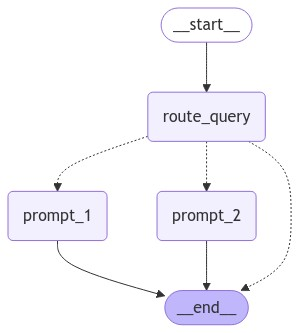

In [14]:
from IPython.display import Image
Image(app.get_graph().draw_mermaid_png())

In [15]:
# Run the app for a flower care question
state = await app.ainvoke({"query": "How to water roses?"})
print(f"Destination: {state['destination']['destination']}")
print(f"Answer: {state['answer']}")


Destination: flower care
Answer: Watering roses properly is crucial for their health and blooming. Here are some tips on how to water roses effectively:

1. **Timing**: Water your roses early in the morning or late in the afternoon to reduce evaporation. Avoid watering during the hottest part of the day.

2. **Method**: Use a soaker hose or drip irrigation system for deep watering. This method delivers water directly to the roots and minimizes water on the foliage, which can help prevent fungal diseases. If using a watering can or hose, direct the water at the base of the plant.

3. **Amount**: Roses typically need about 1-2 inches of water per week, depending on weather conditions. During hot, dry spells, they may need more. Ensure the soil is moist but not soggy.

4. **Soil Check**: Before watering, check the soil moisture by sticking your finger about an inch into the soil. If it feels dry at that depth, it’s time to water.

5. **Mulching**: Apply a layer of mulch around the base of

Destination: flower care
Answer: Watering roses properly is crucial for their health and blooming. Here are some tips on how to water roses effectively:

1. **Timing**: Water your roses early in the morning or late in the afternoon to reduce evaporation. Avoid watering during the hottest part of the day.

2. **Method**: Use a soaker hose or drip irrigation system for deep watering. This method delivers water directly to the roots and minimizes water on the foliage, which can help prevent fungal diseases. If using a watering can or hose, direct the water at the base of the plant.

3. **Amount**: Roses typically need about 1-2 inches of water per week, depending on weather conditions. During hot, dry spells, they may need more. Ensure the soil is moist but not soggy.

4. **Soil Check**: Before watering, check the soil moisture by sticking your finger about an inch into the soil. If it feels dry at that depth, it’s time to water.

5. **Mulching**: Apply a layer of mulch around the base of the roses. Mulch helps retain soil moisture and keeps the roots cool.

6. **Avoid Overhead Watering**: Try to avoid getting the leaves wet, as this can promote diseases. Focus on watering the root zone.

7. **Adjust for Conditions**: Be aware of your local climate and adjust your watering schedule accordingly. In rainy weather, you may need to reduce watering.

By following these guidelines, you can promote healthy growth and vibrant blooms in your rose plants.


In [16]:
# Run the app for a flower care question
state = await app.ainvoke({"query": "How to decorate the wedding venue with flowers?"})
print(f"Destination: {state['destination']['destination']}")
print(f"Answer: {state['answer']}")


Destination: flower decoration
Answer: Decorating a wedding venue with flowers is a beautiful way to enhance the atmosphere and create a memorable experience for the couple and their guests. Here are some tips and ideas for using flowers effectively in wedding venue decoration:

### 1. **Choose a Color Palette**
   - Select a color scheme that complements the wedding theme. Popular combinations include pastels, bold colors, or monochromatic schemes. 

### 2. **Consider the Venue**
   - Assess the venue's style and architecture. A rustic barn may require different floral arrangements than an elegant ballroom. 

### 3. **Entrances and Aisles**
   - Create stunning entrances with large floral arrangements or arches. 
   - Line the aisle with petals, lanterns, or small arrangements to guide guests to the altar.

### 4. **Altar or Ceremony Backdrop**
   - Use flowers to create a focal point for the ceremony. Consider a floral arch, a cascading arrangement, or a backdrop of flowers.

### 5. 

In [17]:
# Run the app for a flower care question
state = await app.ainvoke({"query": "I'm Anna?"})
print(f"Destination: {state['destination']['destination']}")
print(f"Answer: {state['answer']}")


Destination: flower care
Answer: Hi Anna! It's great to meet you. How can I assist you today? Are you looking for flower arrangement tips or ideas?


In [ ]:
hw:2.implement routing cahins when they do not belong to any operational business scenarios?

In [8]:
from dotenv import load_dotenv
load_dotenv()

True

In [26]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, StateGraph
from typing_extensions import TypedDict

# Initialize the LLM model
llm = ChatOpenAI(model="gpt-4o-mini")

# Create prompt templates
flower_care_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an experienced gardener."),
    ("human", "{input}")
])

flower_deco_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a popular flower arrangement master."),
    ("human", "{input}")
])

default_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a universal assistant.The answer does not involve questions related to flowers."),
    ("human", "{input}")
])

# Define chains for each prompt
chain_1 = flower_care_prompt | llm | StrOutputParser()
chain_2 = flower_deco_prompt | llm | StrOutputParser()
chain_default = default_prompt | llm | StrOutputParser()

# Define the routing logic
route_system = "Route the user's query to either flower care or flower decoration expert.If the query does not match either of the above categories, route it to default for general inquiries that do not involve flowers."

route_prompt = ChatPromptTemplate.from_messages([
    ("system", route_system),
    ("human", "{input}")
])

# route_template = route_prompt.messages

# for message in route_template:
#     print(f"Message type: {message.__class__.__name__}")
#     print(f"Message content: {message.prompt}")
#     print("-" * 40)

# print(route_prompt)

# Define schema for the routing output
class RouteQuery(TypedDict):
    destination: str

route_chain = route_prompt | llm.with_structured_output(RouteQuery)

# Define graph state
class State(TypedDict):
    query: str
    destination: RouteQuery
    answer: str

# Define functions for routing and processing each chain
async def route_query(state: State, config: RunnableConfig):
    destination = await route_chain.ainvoke(state["query"], config)
    return {"destination": destination}

async def prompt_1(state: State, config: RunnableConfig):
    return {"answer": await chain_1.ainvoke(state["query"], config)}

async def prompt_2(state: State, config: RunnableConfig):
    return {"answer": await chain_2.ainvoke(state["query"], config)}

async def prompt_default(state: State, config: RunnableConfig):
    return {"answer": await chain_default.ainvoke(state["query"], config)}

# Define the node selection based on the routing decision
# def select_node(state: State) -> str:
#     if state["destination"]["destination"] == "flower_care":
#         return "prompt_1"
#     else:
#         return "prompt_2"

def select_node(state: State) -> str:
    destination = state["destination"]["destination"]
    if destination == "flower_care":
        return "prompt_1"
    elif destination == "flower_deco":
        return "prompt_2"
    else:
        return "prompt_default"

# Build the state graph
graph = StateGraph(State)
graph.add_node("route_query", route_query)
graph.add_node("prompt_1", prompt_1)
graph.add_node("prompt_2", prompt_2)
graph.add_node("prompt_default", prompt_default)

# Add edges between the nodes, starting from routing and following the selection logic
graph.add_edge(START, "route_query")
graph.add_conditional_edges("route_query", select_node)
graph.add_edge("prompt_1", END)
graph.add_edge("prompt_2", END)
graph.add_edge("prompt_default", END)
# Compile the graph into an app
app = graph.compile()

# Run the app for a flower care question
state = await app.ainvoke({"query": "How to water roses?"})
print(f"Destination: {state['destination']['destination']}")
print(f"Answer: {state['answer']}")


Destination: flower care
Answer: Watering roses properly is essential for their health and blooming. Here are some guidelines:

1. **Watering Schedule**: Water roses deeply but infrequently. Generally, this means watering once a week, but you may need to adjust based on your climate and soil conditions.

2. **Time of Day**: The best time to water is in the early morning. This allows the plants to absorb moisture before the heat of the day and reduces the risk of fungal diseases.

3. **Soil Moisture**: Check the soil moisture before watering. The top inch of soil should be dry. Stick your finger into the soil to gauge moisture levels.

4. **Watering Method**: Use a soaker hose or drip irrigation to deliver water directly to the roots. If using a hose or watering can, aim to water at the base of the plant, avoiding wetting the foliage.

5. **Amount of Water**: Roses typically need about 1 inch of water per week. Ensure that the water penetrates the soil to a depth of at least 12 inches.


In [17]:
state = await app.ainvoke({"query": "How to decorate the wedding venue with flowers?"})
print(f"Destination: {state['destination']['destination']}")
print(f"Answer: {state['answer']}")


Destination: flower decoration
Answer: Decorating a wedding venue with flowers can create a stunning and romantic atmosphere. Here are some steps and ideas to help you achieve a beautiful floral arrangement for the big day:

### 1. **Choose a Color Palette**
   - Select colors that complement the wedding theme and the overall decor. Common palettes include pastels, bold colors, or monochromatic schemes.

### 2. **Select the Right Flowers**
   - Choose seasonal flowers that fit your color palette. Popular wedding flowers include roses, peonies, hydrangeas, lilies, and tulips.
   - Consider using a mix of large focal flowers and smaller accent flowers for balance.

### 3. **Create a Floral Plan**
   - **Ceremony Area:**
     - **Altar/Arch:** Decorate with a floral arch or backdrop. Use cascading flowers or greenery for a romantic effect.
     - **Aisle Decorations:** Use flower petals or small arrangements on the aisle chairs or stands.
   - **Reception Area:**
     - **Centerpieces:** 

In [28]:
state = await app.ainvoke({"query": "Who are you？"})
print(f"Destination: {state['destination']['destination']}")
print(f"Answer: {state['answer']}")

Destination: default
Answer: I am a universal assistant designed to provide information and help with a wide range of topics. How can I assist you today?


In [29]:
state = await app.ainvoke({"query": "I'm Anna?"})
print(f"Destination: {state['destination']['destination']}")
print(f"Answer: {state['answer']}")


Destination: default
Answer: Hello, Anna! How can I assist you today?


In [31]:
state = await app.ainvoke({"query": "How to Get into Harvard University?"})
print(f"Destination: {state['destination']['destination']}")
print(f"Answer: {state['answer']}")

Destination: default
Answer: Getting into Harvard University is a highly competitive process that requires careful planning and strong preparation. Here are some steps to help you navigate the admissions process:

1. **Academic Excellence**: 
   - Maintain a high GPA, particularly in challenging courses such as Advanced Placement (AP), International Baccalaureate (IB), or honors classes.
   - Aim for top scores on standardized tests like the SAT or ACT. While Harvard has adopted a test-optional policy, strong scores can still enhance your application.

2. **Extracurricular Activities**: 
   - Engage in meaningful extracurricular activities that demonstrate leadership, commitment, and passion. Quality is often more important than quantity.
   - Consider starting your own initiatives or projects, or taking on leadership roles in clubs or organizations.

3. **Personal Statement and Essays**: 
   - Write compelling personal statements and application essays that reflect your personality, e

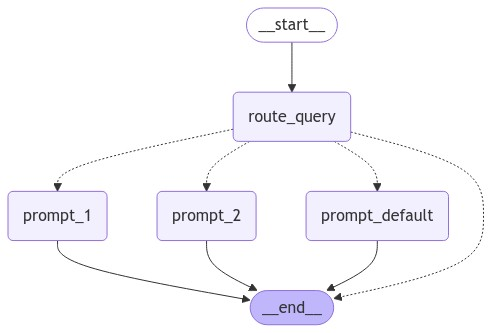

In [30]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())